### 190648C
### VIKASITHA K.S.S.
#### ASSIGNMENT 02

https://github.com/SasininduSV/EN2550-Assignment-02.git

## $Q1$

In [181]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt
import random
#np.random.seed(0)

def generateNoisyPointSet():
    N = 100
    half_n = N//2
    r = 10
    s = r/16
    t = np.random.uniform(0, 2*np.pi, half_n)
    n = s*np.random.randn(half_n)
    x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
    X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
    m, b = -1, 2
    x = np.linspace(-12, 12, half_n)
    y = m*x + b + s*np.random.randn(half_n)
    X_line = np.hstack((x.reshape(half_n, 1) , y.reshape(half_n, 1)))
    X = np.vstack((X_circ, X_line))
    return X,N

X,N = generateNoisyPointSet()

Generate a noisy point set X

### $(a)$

In [182]:
# Estimate the cicle using RANSAC algorithm
def circleEstimate(min_iterations, min_inliers, no_of_points, points, inlier_treshold):
    its = min_iterations
    max_inliers = 0
    while max_inliers < min_inliers or its > 0:
        # Randomly choose 3 points
        sample = random.sample(range(1, no_of_points), 3)
        x1 = np.zeros([3,2])
        for i in range(3):
            x1[i]=points[sample[i]]
        
        # Calculate the coordinates of the center & the radius of the circle passing through those 3 points
        x2 = np.hstack((x1,np.ones((3,1))))
        x3 = (-1*((x1[:,0]*x1[:,0])+(x1[:,1]*x1[:,1]))).reshape(3,1)
        c = np.matmul(np.linalg.inv(x2),x3)
        c_x , c_y = -c[0]/2 , -c[1]/2
        radius = np.sqrt(c_x*c_x + c_y*c_y - c[2])

        if radius > 30:continue
        
        no_of_inliers, inlier_points = inlierCount(points, c_x, c_y, radius, inlier_treshold) # Find inliers
        
        # Check whether it is the best model with most inliers
        if max_inliers < no_of_inliers:
            max_inliers, circle_parameters, best_inlier_points, best_sample = no_of_inliers, [c_x,c_y,radius], inlier_points, x1
        if max_inliers >= min_inliers:
            its-=1
    
    return max_inliers, circle_parameters, best_inlier_points, best_sample

# Check whether a given point is an inlier or not
def isInlier(x, y, cx, cy, r, T):
    r_=(x-cx)**2+(y-cy)**2
    if r-T < np.sqrt(r_) < r+T:
        return True
    else: return False

# Find inliers of a given circle
def inlierCount(points, cx, cy, r, T):
    n=0
    inlier_arr=np.zeros((1,2))
    for i in points:
        if isInlier(i[0], i[1], cx, cy, r, T):
            n+=1
            if not inlier_arr.any():
                inlier_arr[0]=i
            else:
                inlier_arr=np.concatenate((inlier_arr,[i]),axis=0)
    return n,inlier_arr

# calculate the distance of each 2D points from the center (xc, yc)
def calc_R(xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

# calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)
def f_2(c):
    Ri = calc_R(*c)
    return Ri - Ri.mean()

# least square method circle fit
def leastSquareCirc(x,y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2 = calc_R(*center_2)
    R_2 = Ri_2.mean()
    residu_2 = sum((Ri_2 - R_2)**2)
    return round(xc_2,5),round(yc_2,5),round(R_2,5),residu_2

Once 3 points randomly get choosen. Calculate the circle passes through those 3 points. Then, calculate the number of inliers corresponding to that circle. The circle with highest number of inliers is taken as the best estimate. After that, the best-fit circle is computed by using the inlier points of that best sample & $least$ $square$ method.

### $(b)$

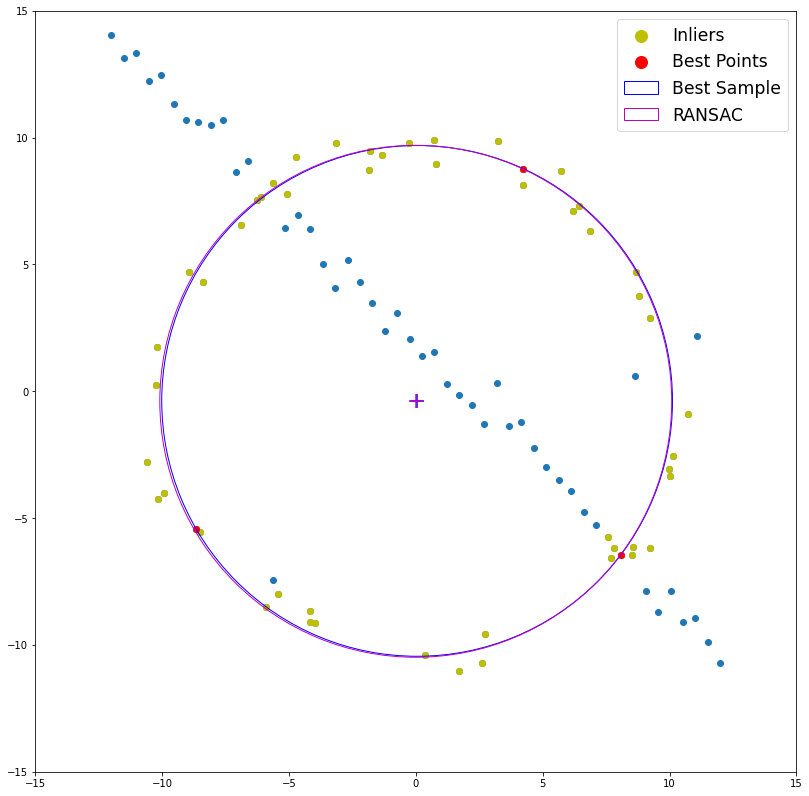

In [183]:
m1, circ, inls, bestpoints = circleEstimate(250,42,N,X,0.9)
x, y = inls[:,0],inls[:,1]

figure, axes = plt.subplots(figsize=(14,14))

# plot the circle estimated from the sample leading to the best estimate
draw_circle = plt.Circle((circ[0], circ[1]), circ[2],fill=False,color='b',label='Best Sample')
axes.scatter(X[:,0], X[:,1]) # Plot points
axes.scatter(circ[0], circ[1],color='b',marker='+',s=180) # Plot center of the best sample cicle
axes.scatter(x, y,color='y',label='Inliers') # Plot inliers
axes.scatter(bestpoints[:,0], bestpoints[:,1],color='r',label='Best Points') # Plot 3-points of the best sample
axes.set_aspect(1)
axes.add_artist(draw_circle)

a,b,c,d = leastSquareCirc(x,y) # Least square circle fit out of inliers

draw_circle = plt.Circle((a, b), c,fill=False,color='m',label='RANSAC') # Plot best fit circle
axes.add_artist(draw_circle)
axes.scatter(a, b,marker='+',c='m',s=180) # Plot center
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.legend(fontsize='xx-large',markerscale=2.0)
plt.show()

Plot of the point set, the circle estimated from the sample leading to the best estimate, this sample of three points, inliers, and the best-fit circle.

## $Q2$

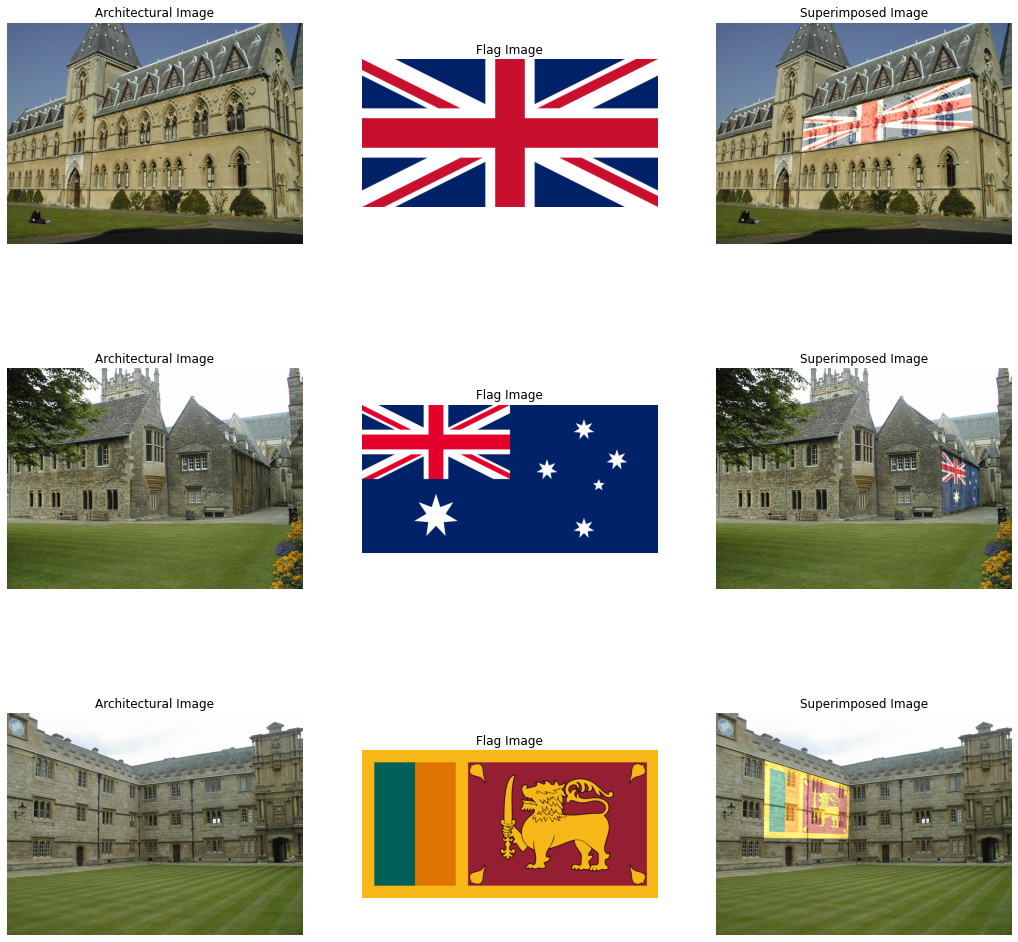

In [189]:
import cv2 as cv

point_matrix = np.zeros((4,2),dtype=np.float32)
 
counter = 0
# mouse-clicking
def mouseClicks(event,x,y,flags,params):
    global counter
    if event == cv.EVENT_LBUTTONDOWN:
        point_matrix[counter] = x,y
        counter = counter + 1
    if counter==4:counter=0

# getting points by mouse-clicking
def gettingPoints(im, win_name):
    cv.imshow(win_name,im)
    cv.setMouseCallback(win_name,mouseClicks)
    cv.waitKey(0)
    cv.destroyAllWindows()

def BGR2RGB(im):
    return cv.cvtColor(im,cv.COLOR_BGR2RGB)

fig , ax = plt.subplots(3 , 3 ,figsize=(18,18))

for j in range(1,4):
    img = cv.imread(r'Assignment-02 Materials\im{}.jpg'.format(j))
    assert img is not None
    flag = cv.imread(r'Assignment-02 Materials\f{}.png'.format(j))
    assert flag is not None

    gettingPoints(img, 'img{}'.format(j))

    # computing homography
    H = cv.getPerspectiveTransform(np.array([[0, 0],[np.shape(flag)[1],0],[0,np.shape(flag)[0]],[np.shape(flag)[1],np.shape(flag)[0]]],dtype=np.float32), point_matrix)
    
    # warping the flag
    warped_f = cv.warpPerspective(flag, H,(np.shape(img)[1],np.shape(img)[0]))
    
    # blending the warped flag on to the architectural image
    result = cv.addWeighted(img, 1, warped_f, 0.6, 0)

    titles = ("Architectural Image" , "Flag Image", "Superimposed Image")

    ax[j-1,0].imshow(BGR2RGB(img))
    ax[j-1,1].imshow(BGR2RGB(flag))
    ax[j-1,2].imshow(BGR2RGB(result))
    for k in range(3):
        ax[j-1,k].axis('off')
        ax[j-1,k].set_title(titles[k])
plt.show()

I chose three architectural images with old buildgings and three different flags. Since those flags are rectangular shaped. I chose quadrangle shaped convenient surfaces on the walls of those buildings to blend the flags. (when blending, weight of the flags have reduced)

## $Q3$

### $(a)$

no of matches = 99


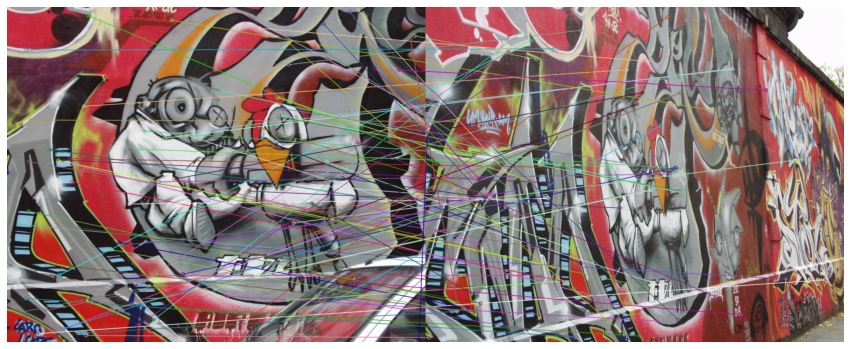

In [185]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def matchSIFTfeatures(img1,img2,ratio):
    img1 = cv.imread(r'Assignment-02 Materials\{}.ppm'.format(img1))
    img2 = cv.imread(r'Assignment-02 Materials\{}.ppm'.format(img2))

    sift = cv.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    pts1,pts2,good = [],[],[]
    
    for m,n in matches:
        if m.distance < ratio*n.distance:
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)
            good.append([m])

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    return img1,img2,kp1,kp2,pts1,pts2,good

img_1,img_5,kp1,kp2,pts1,pts2,good = matchSIFTfeatures("img1","img5",0.75) # compute & match SIFT features

# plotting
img3 = cv.drawMatchesKnn(img_1,kp1,img_5,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
print("no of matches =",len(good))
plt.figure(figsize=(15,10))
plt.imshow(img3)
plt.axis('off')
plt.show()


SIFT features between the Graffiti img1 & img5 by $Flann$ based matcher. 0.75 is used as the distance ratio.

### $(b)$

In [186]:
# checks whether a sift feature point is an inlier or not
def isSiftInlier(p1,p2,H,T):
    P = np.matmul(H,np.append(p1,1))
    P=P/P[-1]
    P = P[:2]-p2
    dis = np.sqrt(P[0]**2 + P[1]**2)
    if dis <= T:
        return True
    else:return False

# calculate sift inlier count
def siftInlierCount(points1, points2, H, T):
    count=0
    l=points1.shape[0]
    inlier_arr1 = np.zeros((1,2))
    inlier_arr2 = np.zeros((1,2))
    for i in range(l):
        if isSiftInlier(points1[i],points2[i],H,T):
            count+=1
            if not inlier_arr1.any():
                inlier_arr1[0] = points1[i]
                inlier_arr2[0] = points2[i]
            else:
                inlier_arr1 = np.concatenate((inlier_arr1, [points1[i]]), axis=0)
                inlier_arr2 = np.concatenate((inlier_arr2, [points2[i]]), axis=0)
    return count,inlier_arr1,inlier_arr2

# choose a random sample of 4 sift feature points pairs
def randomSample(points1, points2, n):
    sample = np.random.choice(np.shape(points1)[0],n,replace=False)
    x1 = np.zeros([n,2])
    x2 = np.zeros([n,2])
    for i in range(n):
        x1[i]=points1[sample[i]]
        x2[i]=points2[sample[i]]
    return x1,x2

# calculate homography matrix using 4 sift feature points pairs
def calculateHomography(points1,points2):
    A = np.zeros((8,9))
    for i in range(4):
        A[i*2,3:6] = np.append(points1[i],[1])
        A[i*2,6:] = -points2[i,1]*np.append(points1[i],[1])
        A[(i*2)+1,:3] = np.append(points1[i],[1])
        A[(i*2)+1,6:] = -points2[i,0]*np.append(points1[i],[1])
    W = np.matmul(A.T,A)
    val, vec = np.linalg.eig(W)
    min_eig = vec[:,np.argmin(np.absolute(val))]
    H = np.reshape(min_eig,(3,3))
    H = H/H[2,2]
    return H

# compute the homography using RANSAC
def h_with_RANSAC(its,point_set1,point_set2,T):
    max_inliers=0
    for k in range(its):
        p1,p2 = randomSample(point_set1, point_set2, 4)
        H = calculateHomography(p1,p2)
        no,a1,a2 = siftInlierCount(point_set1,point_set2,H,T)
        if no > max_inliers:
            max_inliers = no
            bestH = H
            ar1,ar2,pp1,pp2 = a1, a2,p1,p2
    return max_inliers, bestH, ar1, ar2,pp1,pp2


In [187]:
m,H1to5,A1,A2,xx,yy = h_with_RANSAC(10000,pts1,pts2,5) # H1to5 - img1 to img5 computed homography

# data set given homography of img1 to img 5
given_H1to5 = np.array([[6.2544644e-01, 5.7759174e-02, 2.2201217e+02],
                    [2.2240536e-01, 1.1652147e+00, -2.5605611e+01],
                    [4.9212545e-04, -3.6542424e-05, 1.0000000e+00]])

ssd_1to5_direct = np.sum((H1to5-given_H1to5)**2)
print("Sum of square difference between computed 1to5 homography & given one =",ssd_1to5_direct)

img1,img2,kp1,kp2,pts1,pts2,good = matchSIFTfeatures("img1","img3",0.65)
m,H1to3,A1,A2,xx,yy = h_with_RANSAC(7500,pts1,pts2,1.5)

img1,img2,kp1,kp2,pts1,pts2,good = matchSIFTfeatures("img3","img5",0.65)
m,H3to5,A1,A2,xx,yy = h_with_RANSAC(7500,pts1,pts2,1.5)

_H1to5 = np.matmul(H3to5,H1to3)
ssd1to5 = np.sqrt((np.sum((_H1to5/(_H1to5[-1,-1])-given_H1to5)**2)))
print("\nCompute Graffiti img 1to3 homography & Graffiti img 3to5 homography, then by using those two, we can compute Graffiti img 1to5 homography")
print("\nSum of square difference between newly computed 1to5 homography & given one =",ssd1to5)
print("\nComputed homography =", _H1to5)

Sum of square difference between computed 1to5 homography & given one = 163554.76707617345

Compute Graffiti img 1to3 homography & Graffiti img 3to5 homography, then by using those two, we can compute Graffiti img 1to5 homography

Sum of square difference between newly computed 1to5 homography & given one = 2.9217178496729255

Computed homography = [[ 6.38780124e-01  6.39715803e-02  2.31282457e+02]
 [ 2.19921777e-01  1.20847285e+00 -2.36153714e+01]
 [ 4.89340499e-04 -3.12446822e-05  1.04027270e+00]]


If the homography of img1 to img5 is directly computed using SIFT feature matches of img1 & img5. The error is very high (163554.767).\
Therefore, firstly I computed the homography of Graffiti img1 to img3, then I computed the homography of Graffiti img3 to img5. By using those two homography matrices, I computed the homography of img1 to img5 (by matrix multiplication). Then, the error of that homography is very low.(2.9217)

### $(c)$

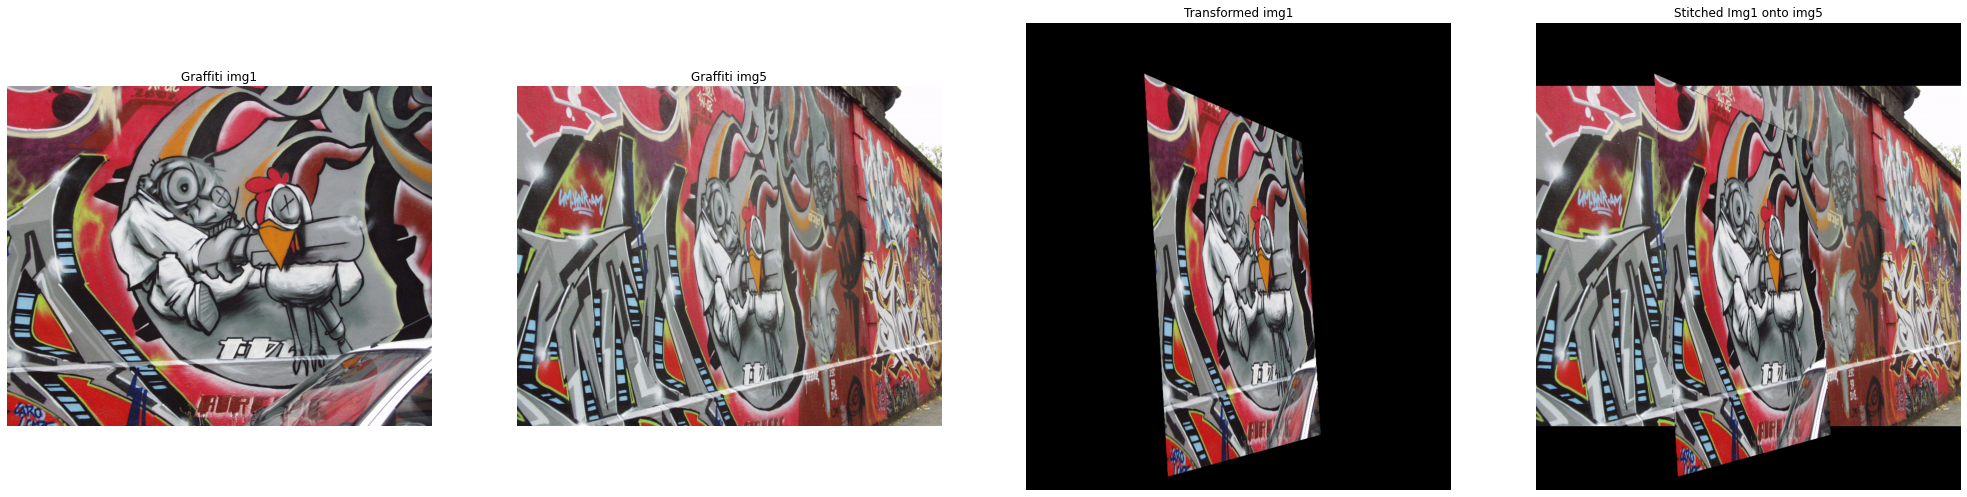

In [188]:
def stitching():
    frame = np.zeros((img_5.shape[0]+240,img_5.shape[1]))
    Ht = np.array([[1,0,0],[0,1,120],[0,0,1]],dtype=float)
    img_1_=cv.add(img_1,1)
    img1 = cv.warpPerspective(img_5,Ht,frame.shape[1::-1])
    img2 = cv.warpPerspective(img_1_,Ht @ _H1to5,frame.shape[1::-1])

    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols]

    img2gray = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
    ret, mask = cv.threshold(img2gray, 0, 255, cv.THRESH_BINARY)
    mask_inv = cv.bitwise_not(mask)

    img1_bg = cv.bitwise_and(roi,roi,mask = mask_inv)

    img2_fg = cv.bitwise_and(img2,img2,mask = mask)

    dst = cv.add(img1_bg,img2_fg)
    img1[0:rows, 0:cols ] = dst
    fig, ax = plt.subplots(1, 4, figsize=(35, 10))
    images = ['img_1_','img_5','img2','img1']
    titles = ['Graffiti img1','Graffiti img5','Transformed img1', 'Stitched Img1 onto img5']

    for i in range(4):
        ax[i].imshow(BGR2RGB(eval(images[i])))
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    plt.show()

# stitch img1.ppm onto img5.ppm using a mask
stitching()

Stitched img1.ppm onto img5.ppm using above computed homography.